In [1]:
import seaborn as sns
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np
from networkx.algorithms import bipartite

In [36]:
df = pd.read_csv('../data/review.csv')
df.reviewTime = pd.to_datetime(df.reviewTime)
print(df.shape)
# df = df[df['reviewTime'] > '2012-01-01']
# print(df.shape)
df.head(5)

(92325, 13)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,cleanedText,nltk,distilbert_positive,distilbert_negative
0,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",i had dirt 2 on xbox 360 and it was an okay ga...,4,DIRT 3,1308009600,2011-06-14,dirt xbox 360 okay game started playing games ...,0.9136,0.992070,0.007930
1,A1QJJU33VNC4S7,0700099867,D@rkFX,"[0, 1]",i initially gave this one star because it was ...,4,A great game ruined by Microsoft's account man...,1352851200,2012-11-14,initially gave one star crashing constantly re...,0.4019,0.995254,0.004746
2,ANW6EGY12V5XS,0700099867,Henri Savin,"[0, 0]",i have been playing car racing games since the...,5,A 5 stars winner!,1318982400,2011-10-19,playing car racing games since early beginning...,0.9926,0.754624,0.245376
3,AHT34BRYFBFT1,0700099867,hewimp,"[0, 1]",dirt 3 on dvdi collect racing games so had to ...,5,Cars,1388275200,2013-12-29,dirt dvdi collect racing games add collections...,-0.3400,0.988628,0.011372
4,A248LSBZT4P38V,0700099867,Joseph R. Kennedy,"[0, 0]",i bought this and the key didn't work. it was...,1,"It might have been a good game, but I never fo...",1404086400,2014-06-30,bought key work gift recipient able solve prob...,0.7651,0.932582,0.067418


In [28]:
print(min(df['reviewTime']), max(df['reviewTime']))

2006-01-02 00:00:00 2014-07-22 00:00:00


### Unweighted graph

In [41]:
g_w = nx.Graph()
g_w.add_nodes_from(df['reviewerID'].tolist(), bipartite=0)
g_w.add_nodes_from(df['asin'].tolist(), bipartite=1)
edges = list(zip(df['reviewerID'].tolist(), df['asin'].tolist()))
g_w.add_edges_from(edges)

In [42]:
c_g_w = bipartite.weighted_projected_graph(g_w, list(set(df['reviewerID'])))
edges = c_g_w.edges

### Rating distribution

In [5]:
print(len(df[df['nltk'] >= 0.75]['nltk'].tolist()) / len(df['nltk'].tolist()))
print(len(df[df['overall'] >= 4]['overall'].tolist()) / len(df['overall'].tolist()))

0.72160303276469
0.7482805307338207


<AxesSubplot:title={'center':'Review rating (discrete) distribution'}, xlabel='overall', ylabel='Count'>

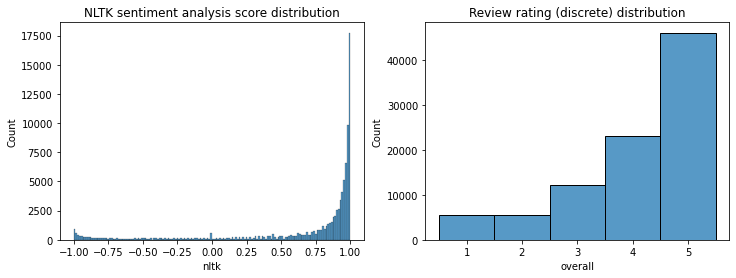

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set(title='NLTK sentiment analysis score distribution')
ax2.set(title='Review rating (discrete) distribution')
sns.histplot(ax=ax1, data=df, x='nltk')
sns.histplot(ax=ax2, data=df, x='overall', discrete=True)
# plt.hist(df['compound'].tolist())

<AxesSubplot:xlabel='distilbert_positive', ylabel='Count'>

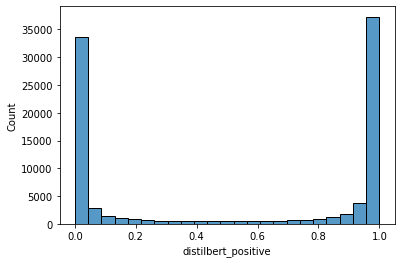

In [49]:
sns.histplot(data=df, x='distilbert_positive')

### Weighted graph

In [43]:
# for rid, pid
g = nx.Graph()
g.add_nodes_from(df['reviewerID'].tolist(), bipartite=0)
g.add_nodes_from(df['asin'].tolist(), bipartite=1)
edges = list(zip(df['reviewerID'].tolist(), df['asin'].tolist(), df['overall'].tolist()))
g.add_weighted_edges_from(edges)

In [44]:
print(len(set(df['user_id'].tolist())))
c_nodes = [n for n, d in g.nodes(data=True) if d['bipartite'] == 0]
p_nodes = [n for n, d in g.nodes(data=True) if d['bipartite'] == 1]
print(len(c_nodes), len(p_nodes))

4939
4939 9899


In [45]:
print("# connected components:", nx.number_connected_components(g))
largest_cc = g.subgraph(max(nx.connected_components(g), key=len))
print("% largest connected component:", largest_cc.number_of_nodes() / len(g.nodes))
print("Edge set size of largest cc:", largest_cc.number_of_edges() / len(g.edges))
c_degrees = [g.degree(i) for i in c_nodes]
p_degrees = [g.degree(i) for i in p_nodes]
print("Average degree of customers:", np.mean(c_degrees))
print("Max degree of customers:", np.max(c_degrees))
print("Average degree of products:", np.mean(p_degrees))
print("Max degree of products:", np.max(p_degrees))

# connected components: 1
% largest connected component: 1.0
Edge set size of largest cc: 1.0
Average degree of customers: 18.693055274347035
Max degree of customers: 482
Average degree of products: 9.326699666632994
Max degree of products: 290


In [14]:
cc = bipartite.clustering(g)
print('Average bipartite clustering coefficient:', np.mean(list(cc.values())))

Average bipartite clustering coefficient: 0.06713400793127101


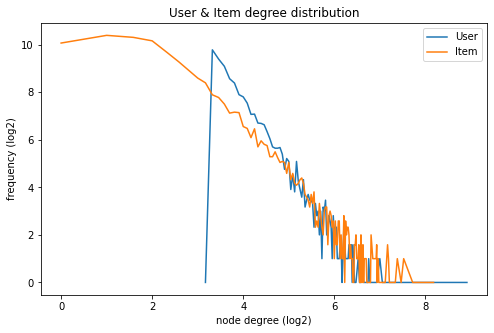

In [46]:
c_degree_dist = collections.OrderedDict(sorted(collections.Counter(c_degrees).items()))
p_degree_dist = collections.OrderedDict(sorted(collections.Counter(p_degrees).items()))
plt.figure(figsize=(8, 5))
c_x = list(c_degree_dist.keys())
c_y = list(c_degree_dist.values())
p_x = list(p_degree_dist.keys())
p_y = list(p_degree_dist.values())
plt.plot(np.log2(c_x), np.log2(c_y), label='User')
plt.plot(np.log2(p_x), np.log2(p_y), label='Item')
plt.xlabel("node degree (log2)")
plt.ylabel("frequency (log2)")
plt.title("User & Item degree distribution")
plt.legend()

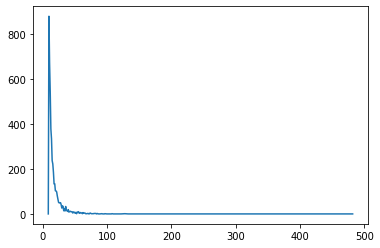

In [47]:
plt.plot(c_x, c_y, label='User')

In [16]:
import powerlaw
from scipy.stats import kstest
dist = powerlaw.Power_Law(data=c_y, discrete=True, xmin=1.0) # fill the observation sequence (the in-degree sequence)
print('fit: alpha=%5.3f' % dist.alpha)
kstest(c_y, dist.cdf)

fit: alpha=1.411


KstestResult(statistic=0.336283185840708, pvalue=6.713031206228378e-12)

In [17]:
dist = powerlaw.Power_Law(data=p_y, discrete=True, xmin=1.0) # fill the observation sequence (the in-degree sequence)
print('fit: alpha=%5.3f' % dist.alpha)
kstest(p_y, dist.cdf)

fit: alpha=1.367


KstestResult(statistic=0.21804511278195488, pvalue=4.94919528575619e-06)

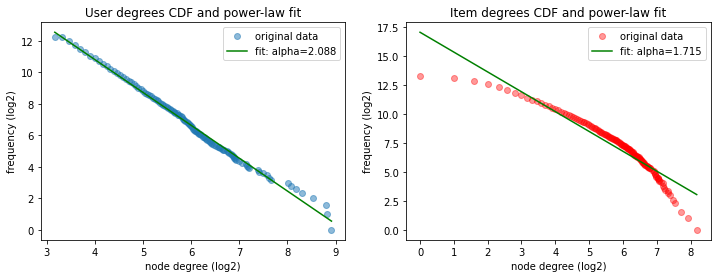

In [20]:
from scipy import stats
c_y_cum = [0] * len(c_y)
c_y_cum[-1] = c_y[-1]
for i in range(len(c_y) - 2, -1, -1):
    c_y_cum[i] = c_y_cum[i + 1] + c_y[i]
c_res = stats.linregress(np.log2(c_x), np.log2(c_y_cum))

p_y_cum = [0] * len(p_y)
p_y_cum[-1] = p_y[-1]
for i in range(len(p_y) - 2, -1, -1):
    p_y_cum[i] = p_y_cum[i + 1] + p_y[i]
p_res = stats.linregress(np.log2(p_x), np.log2(p_y_cum))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.log2(c_x), np.log2(c_y_cum), 'o', alpha=0.5, label='original data')
ax1.plot(np.log2(c_x), c_res.intercept + c_res.slope*np.log2(c_x), 'g', label='fit: alpha=%5.3f' % (-c_res.slope))
ax1.set(xlabel='node degree (log2)', ylabel='frequency (log2)', title='User degrees CDF and power-law fit')
ax1.legend()

ax2.plot(np.log2(p_x), np.log2(p_y_cum), 'o', color='r', alpha=0.4, label='original data')
ax2.plot(np.log2(p_x), p_res.intercept + p_res.slope*np.log2(p_x), 'g', label='fit: alpha=%5.3f' % (-p_res.slope))
ax2.set(xlabel='node degree (log2)', ylabel='frequency (log2)', title='Item degrees CDF and power-law fit')
ax2.legend()

In [48]:
nx.write_gexf(g, 'bipartite.gexf')

### Find the customers that have the most shared reviews with other customers

In [21]:
def find_most_similar(pG: nx.Graph):
    """
    Find the persons that are most similar to other persons.
    """
    dcs = pd.Series(nx.degree_centrality(pG))
    dcs = dcs.sort_values(ascending=False)
    return dcs.head(10)
c_g = bipartite.weighted_projected_graph(g, list(set(df['user_id'].tolist())))
find_most_similar(c_g)

A2QHS1ZCIQOL7E    0.722357
AFV2584U13XP3     0.704536
A3V6Z4RCDGRC44    0.692791
AJKWF4W7QD4NS     0.615431
A29BQ6B90Y1R5F    0.607128
A20DZX38KRBIT8    0.568246
A1AISPOIIHTHXX    0.536249
A1MRPX3RM48T2I    0.497975
AJIDIVBILJKO0     0.469218
A2A0FBLKJN4ZY5    0.464763
dtype: float64

In [22]:
c_weights = []
for e in c_g.edges:
    c_weights.append(c_g.get_edge_data(*e).get('weight', 1))
print("Avg weight of projected network (user):", np.mean(c_weights))

Avg weight of projected network (user): 1.356398008432412


### Find the products that have the most shared reviewers with other products

In [24]:
p_g = bipartite.weighted_projected_graph(g, list(set(df['asin'])))
find_most_similar(p_g)

B0009VXBAQ    0.376642
B000FQ9QVI    0.336533
B000ERVMI8    0.308042
B000FRU0NU    0.305819
B000FQ2D5E    0.293797
B000FQ9R4E    0.290463
B00BGA9WK2    0.287836
B000UW21A0    0.286826
B0015AARJI    0.279349
B000FO4KO8    0.277228
dtype: float64

In [25]:
p_weights = []
for e in p_g.edges:
    p_weights.append(p_g.get_edge_data(*e).get('weight', 1))
print("Avg weight of projected network (user):", np.mean(p_weights))

Avg weight of projected network (user): 1.2243244592368538


### Visualization of network (smaller set)

In [11]:
import pandas as pd
df_s = pd.read_csv('data/review-sentiment.csv')
df_s.reviewTime = pd.to_datetime(df_s.reviewTime)
print(df_s.shape)
df_s = df_s[df_s['reviewTime'] > '2014-07-07']
print(df_s.shape)
df_s.head(5)

(231780, 14)
(1537, 14)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,neg,neu,pos,compound,sentiment
78,A26HSO6VAFB2V4,9861019731,NaN,"[0, 0]",it works perfectly! nothing is wrong with it.,5,Perfect!,1405209600,2014-07-13,0.000,0.228,0.772,0.7753,positive
377,A1VA4Z4B7Y74KY,B00000DMAQ,Brad,"[0, 0]",great game!,5,Five Stars,1404777600,2014-07-08,0.000,0.196,0.804,0.6249,positive
633,A134F9G6MBP6MQ,B00000DMB3,Ashley,"[0, 0]",i was worried about getting this but i did any...,5,I was worried because it was Used-Acceptable b...,1405036800,2014-07-11,0.146,0.464,0.391,0.8126,positive
1007,A3OU09O34BC73,B00000I1BF,NaN,"[0, 0]",classic game for the ps1. i love it and it sti...,5,so fun!!,1405209600,2014-07-13,0.046,0.512,0.442,0.9436,positive
1678,A1VA4Z4B7Y74KY,B00000J97G,Brad,"[0, 0]",must i say more,5,Five Stars,1404777600,2014-07-08,0.000,1.000,0.000,0.0000,neutral


In [13]:
import networkx as nx
g_s = nx.Graph()
g_s.add_nodes_from(df_s['reviewerID'].tolist(), bipartite=0)
g_s.add_nodes_from(df_s['asin'].tolist(), bipartite=1)
edges = list(zip(df_s['reviewerID'].tolist(), df_s['asin'].tolist(), df_s['compound'].tolist()))
g_s.add_weighted_edges_from(edges)

<AxesSubplot:>

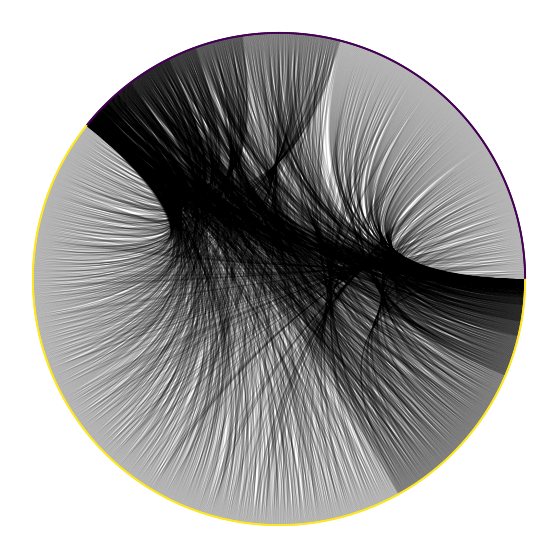

In [ ]:
import nxviz as nv
import matplotlib.pyplot as plt
for n, d in g_s.nodes(data=True):
    g_s.nodes[n]['degree'] = g_s.degree(n)
fig, ax = plt.subplots(figsize=(10, 10))
nv.circos(g_s, sort_by="degree", group_by="bipartite", node_color_by="bipartite", node_enc_kwargs={"size_scale": 3})

In [ ]:
# nx.connected_components(g)
s = [g_s.subgraph(c).copy() for c in nx.connected_components(g_s)]

In [ ]:
for i in s:
    print(len(i.nodes))

1565
6
2
24
6
9
4
7
2
3
7
4
6
6
13
2
6
3
3
2
2
29
2
2
3
2
11
10
3
5
3
7
3
2
2
6
8
2
3
3
2
5
2
3
4
2
2
2
2
3
2
2
2
2
3
2
3
4
4
3
2
4
6
2
2
4
2
2
2
2
2
5
2
2
2
8
2
3
2
10
2
2
2
2
4
10
5
2
4
3
2
2
2
2
2
4
2
2
2
3
2
2
2
2
2
2
6
2
3
2
6
3
2
2
2
2
2
2
3
4
2
8
2
6
2
2
2
6
2
12
2
3
2
4
2
3
2
2
2
2
4
3
2
4
2
3
2
4
2
2
6
2
2
3
4
2
2
2
2
2
2
2
2
4
3
2
2
2
2
3
2
2
8
2
2
3
2
2
3
2
3
2
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
5
3
2
2
2
2
2
2
2
2
4
2
3
3
3
2
2
2
2
3
2
2
2
4
2
2
2
2
4
2
2
3
2
2
2
2
2
3
3
2
2
3
2
2
3
3
2
3
2
2
2
3
2
2
2
2
4
2
2


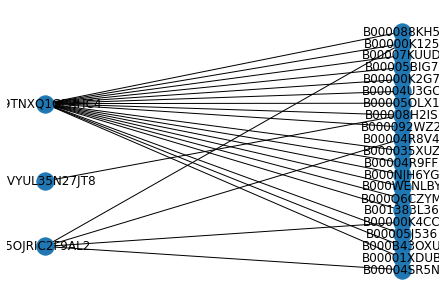

In [ ]:
from networkx.algorithms import bipartite
pos = nx.bipartite_layout(s[3], list(set(df_s['reviewerID'].tolist())))
nx.draw(s[3], pos=pos, with_labels=True)
plt.show()

/opt/homebrew/lib/python3.10/site-packages/nxviz/api.py:275: UserWarning: As of nxviz 0.7, the object-oriented API is being deprecated in favour of a functional API. Please consider switching your plotting code! The object-oriented API wrappers remains in place to help you transition over. A few changes between the old and new API exist; please consult the nxviz documentation for more information. When the 1.0 release of nxviz happens, the object-oriented API will be dropped entirely.
  warnings.warn(


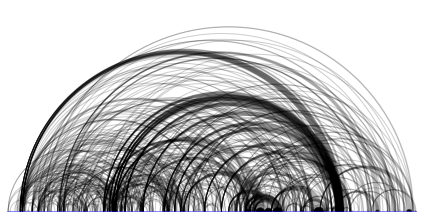

In [14]:
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import nxviz as nv
c_g_s = bipartite.weighted_projected_graph(g_s, df_s['reviewerID'])
a = nv.ArcPlot(c_g_s, edge_width='weight')
plt.tight_layout()